# Collect Orbit and Ground Track

This example demonstrates how to use direct function calls of the low-level TAT-C library to collect satellite orbit and ground tracks.

Similar to the _Collect Observations_ example, the first steps are to define the satellites for the mission. This example again uses the NOAA-20 satellite with a two-line elements model from July 2022 and a VIIRS instrument with field of regard computed based on a 834km altitude and 3000km swath width. This example also adds an operational requirement that targets must be sunlit for valid observations.

In [1]:
from tatc import utils
from tatc.schemas import Instrument, Satellite, TwoLineElements

viirs = Instrument(
    name="VIIRS",
    field_of_regard=utils.swath_width_to_field_of_regard(834000, 3000000),
    req_target_sunlit=True,
)
noaa20 = Satellite(
    name="NOAA 20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
            "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
        ]
    ),
    instruments=[viirs],
)

Next, we can identify the starting and ending times and sampling interval of a sample mission period. The starting time is noon UTC on July 14, 2022 and the ending time is 2 hours later (noon UTC on July 16, 2022). The sampling frequency is set to 2 minutes.

In [2]:
from datetime import datetime, timedelta, timezone
import pandas as pd

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(hours=2)
delta = timedelta(minutes=2)
times = pd.date_range(start, end, freq=delta)
display(times)

DatetimeIndex(['2022-07-14 12:00:00+00:00', '2022-07-14 12:02:00+00:00',
               '2022-07-14 12:04:00+00:00', '2022-07-14 12:06:00+00:00',
               '2022-07-14 12:08:00+00:00', '2022-07-14 12:10:00+00:00',
               '2022-07-14 12:12:00+00:00', '2022-07-14 12:14:00+00:00',
               '2022-07-14 12:16:00+00:00', '2022-07-14 12:18:00+00:00',
               '2022-07-14 12:20:00+00:00', '2022-07-14 12:22:00+00:00',
               '2022-07-14 12:24:00+00:00', '2022-07-14 12:26:00+00:00',
               '2022-07-14 12:28:00+00:00', '2022-07-14 12:30:00+00:00',
               '2022-07-14 12:32:00+00:00', '2022-07-14 12:34:00+00:00',
               '2022-07-14 12:36:00+00:00', '2022-07-14 12:38:00+00:00',
               '2022-07-14 12:40:00+00:00', '2022-07-14 12:42:00+00:00',
               '2022-07-14 12:44:00+00:00', '2022-07-14 12:46:00+00:00',
               '2022-07-14 12:48:00+00:00', '2022-07-14 12:50:00+00:00',
               '2022-07-14 12:52:00+00:00', '2022-0

The `collect_orbit_track` method can be called generates points representing the orbital motion of the satellite during the mission.  Results are formatted as a flat GeoDataFrame which is similar to a regular pandas DataFrame with a geospatial column labeled `geometry`. Other columns:
 * `time`: sample time
 * `swath_width`: projected instrument swath width (m) based on the specified field of regard
 * `valid_obs`: boolean whether the observation is "valid" given instrument operational requirements (e.g., sunlit target)

In [3]:
from tatc.analysis import collect_orbit_track

results = collect_orbit_track(noaa20, times)
display(results)

,time,satellite,instrument,swath_width,valid_obs,geometry
0,2022-07-14 12:00:00+00:00,NOAA 20,VIIRS,2.981788e+06,True,POINT Z (21.95297 -4.30943 830100.44549)
1,2022-07-14 12:02:00+00:00,NOAA 20,VIIRS,2.976785e+06,True,POINT Z (20.37537 2.74586 829026.77293)
2,2022-07-14 12:04:00+00:00,NOAA 20,VIIRS,2.974387e+06,True,POINT Z (18.78475 9.80113 828511.60322)
3,2022-07-14 12:06:00+00:00,NOAA 20,VIIRS,2.974522e+06,True,POINT Z (17.14676 16.85117 828540.60607)
4,2022-07-14 12:08:00+00:00,NOAA 20,VIIRS,2.976972e+06,True,POINT Z (15.42098 23.89045 829066.98938)
...,...,...,...,...,...,...
56,2022-07-14 13:52:00+00:00,NOAA 20,VIIRS,2.982751e+06,True,POINT Z (-12.31929 32.67577 830307.18256)
57,2022-07-14 13:54:00+00:00,NOAA 20,VIIRS,2.988980e+06,True,POINT Z (-14.47115 39.66645 831642.23762)
58,2022-07-14 13:56:00+00:00,NOAA 20,VIIRS,2.996045e+06,True,POINT Z (-16.99316 46.61973 833154.32481)
59,2022-07-14 13:58:00+00:00,NOAA 20,VIIRS,3.003364e+06,True,POINT Z (-20.10798 53.51795 834718.65125)


The results can be visualized using a plot.

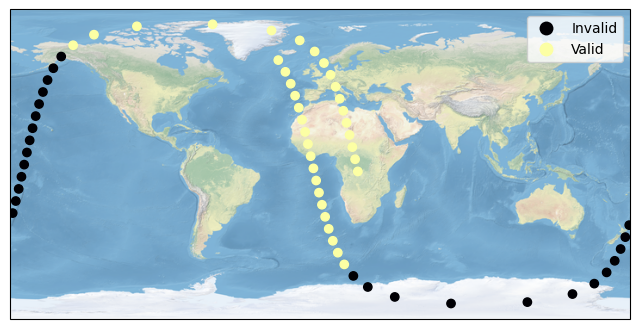

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

results["valid"] = results.apply(
    lambda r: "Valid" if r.valid_obs else "Invalid", axis=1
)

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})

results.plot(
    column="valid",
    legend=True,
    cmap="inferno",
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.stock_img()
ax.set_global()
plt.show()

The `collect_ground_track` method projects a ground track using knowledge of the instrument. The default setting applies a buffer equivalent to the half swath width to each point in the EPSG:4087 World Equidistant Cylindrical coordinate system. The resulting Polygon geometry is automatically split into a MultiPolygon when crossing the anti-meridian (+/- 180 degrees longitude) and/or the north/south pole (+/- 90 degrees latitude).

In [5]:
from tatc.analysis import collect_ground_track

results = collect_ground_track(noaa20, times)
display(results)

,time,satellite,instrument,swath_width,valid_obs,geometry
0,2022-07-14 12:00:00+00:00,NOAA 20,VIIRS,2.981788e+06,True,"POLYGON Z ((35.3459 -4.30943 0, 35.28141 -5.62..."
1,2022-07-14 12:02:00+00:00,NOAA 20,VIIRS,2.976785e+06,True,"POLYGON Z ((33.74583 2.74586 0, 33.68145 1.435..."
2,2022-07-14 12:04:00+00:00,NOAA 20,VIIRS,2.974387e+06,True,"POLYGON Z ((32.14444 9.80113 0, 32.08011 8.491..."
3,2022-07-14 12:06:00+00:00,NOAA 20,VIIRS,2.974522e+06,True,"POLYGON Z ((30.50705 16.85117 0, 30.44272 15.5..."
4,2022-07-14 12:08:00+00:00,NOAA 20,VIIRS,2.976972e+06,True,"POLYGON Z ((28.79228 23.89045 0, 28.72789 22.5..."
...,...,...,...,...,...,...
56,2022-07-14 13:52:00+00:00,NOAA 20,VIIRS,2.982751e+06,True,"POLYGON Z ((1.07796 32.67577 0, 1.01345 31.362..."
57,2022-07-14 13:54:00+00:00,NOAA 20,VIIRS,2.988980e+06,True,"POLYGON Z ((-1.04592 39.66645 0, -1.11056 38.3..."
58,2022-07-14 13:56:00+00:00,NOAA 20,VIIRS,2.996045e+06,True,"POLYGON Z ((-3.53619 46.61973 0, -3.60099 45.3..."
59,2022-07-14 13:58:00+00:00,NOAA 20,VIIRS,3.003364e+06,True,"POLYGON Z ((-6.61814 53.51795 0, -6.6831 52.19..."


While fast, the EPSG:4087 coordinate reference frame is not accurate near the poles, as seen in the plot below.

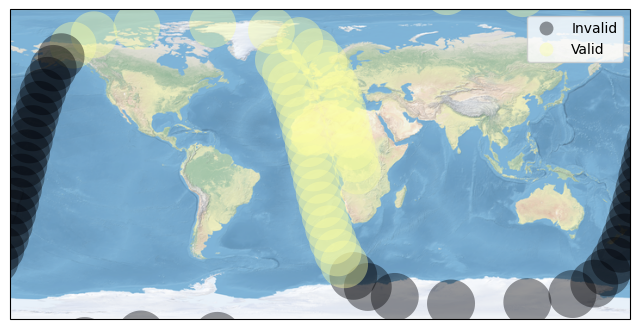

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

results["valid"] = results.apply(
    lambda r: "Valid" if r.valid_obs else "Invalid", axis=1
)

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})

results.plot(
    column="valid", 
    edgecolor="none", 
    alpha=0.4, 
    legend=True, 
    cmap="inferno", 
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.stock_img()
ax.set_global()
plt.show()

Alternatively, setting `crs="utm"` uses the Universal Transverse Mercator (UTM) coordinate reference system to more accurately project swath width near the poles. Note that UTM does not cover the regions above 84 degrees or below -80 degrees latitude. These regions instead use the Unified Polar Stereographic (UPS) CRS; however, with poor performance close to the transition point between zones.

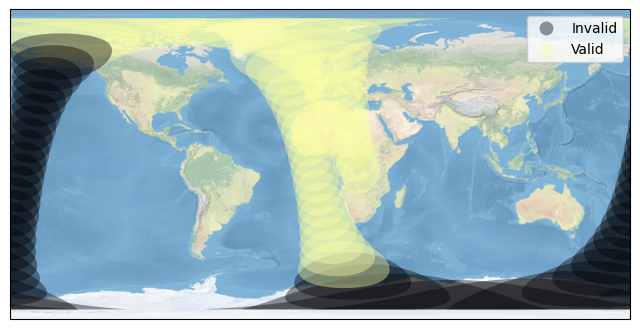

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

results = collect_ground_track(noaa20, times, crs="utm")

results["valid"] = results.apply(
    lambda r: "Valid" if r.valid_obs else "Invalid", axis=1
)

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})

results.plot(
    column="valid", 
    edgecolor="none", 
    alpha=0.4, 
    legend=True, 
    cmap="inferno", 
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.stock_img()
ax.set_global()
plt.show()

The results can also be processed using `compute_ground_track` to dissolve geometries.

Point method (default CRS) completed in 0.14 seconds


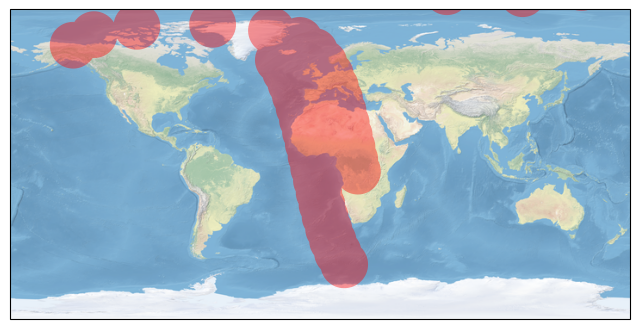

Point method (UTM CRS) completed in 2.07 seconds


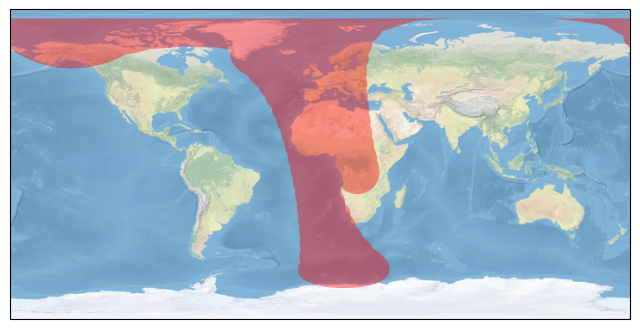

Line method (default CRS) completed in 0.10 seconds


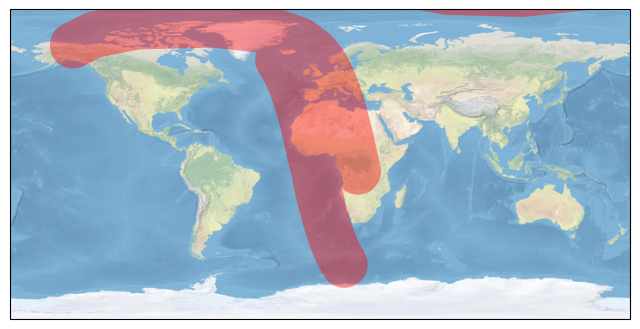

In [8]:
from tatc.analysis import compute_ground_track

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time

t = time.time()
results = compute_ground_track(noaa20, times, method="point")
print(f"Point method (default CRS) completed in {time.time() - t:.2f} seconds")
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})
ax = results.plot(facecolor="r", edgecolor="none", alpha=0.4, zorder=1, ax=ax, transform=ccrs.PlateCarree())
ax.stock_img()
ax.set_global()
plt.show()

t = time.time()
results = compute_ground_track(noaa20, times, crs="utm", method="point")
print(f"Point method (UTM CRS) completed in {time.time() - t:.2f} seconds")
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})
ax = results.plot(facecolor="r", edgecolor="none", alpha=0.4, zorder=1, ax=ax, transform=ccrs.PlateCarree())
ax.stock_img()
ax.set_global()
plt.show()

t = time.time()
results = compute_ground_track(noaa20, times, method="line")
print(f"Line method (default CRS) completed in {time.time() - t:.2f} seconds")
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})
ax = results.plot(facecolor="r", edgecolor="none", alpha=0.4, zorder=1, ax=ax, transform=ccrs.PlateCarree())
ax.stock_img()
ax.set_global()
plt.show()